In [1]:
import os
import random
from PIL import ImageOps

import torch
from torch import nn
from torchvision import datasets, models
from torchvision.transforms import v2
from torch.utils.data import DataLoader
from torchsummary import summary

import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.metrics import confusion_matrix
from sklearn.metrics import f1_score

In [2]:
device= torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

In [3]:
weights= models.RegNet_Y_800MF_Weights.DEFAULT

transform= weights.transforms()
print(transform)

ImageClassification(
    crop_size=[224]
    resize_size=[232]
    mean=[0.485, 0.456, 0.406]
    std=[0.229, 0.224, 0.225]
    interpolation=InterpolationMode.BILINEAR
)


In [4]:
mean=transform.mean
std=transform.std

train_transform = v2.Compose([
    v2.ToImage(),
    v2.ToDtype(torch.float32, scale=True),
    v2.Normalize(mean=mean, std=std)
])

class LetterboxPad:
    """
    Pads images with black borders to make them square.
    This prevents distortion when resizing.
    """
    def __call__(self, img):
        w, h = img.size
        max_dim = max(w, h)
        padding = ImageOps.pad(img, (max_dim, max_dim), color="black", centering=(0.5, 0.5))
        return padding
    
test_transform = v2.Compose([
    LetterboxPad(),
    transform
])


In [5]:
train_dataset= datasets.ImageFolder(root= r'D:\ASL_Project\augmented_dataset2', transform= train_transform)

label_map = {'rejected': 0, 'approved': 1}

train_dataset.targets = [
    label_map[train_dataset.classes[label]]
    for label in train_dataset.targets
]

train_loader= DataLoader(train_dataset, batch_size=64 , shuffle= True, num_workers= 4, pin_memory= True)

In [6]:
test_dataset= datasets.ImageFolder(root= r'D:\ASL_Project\dataset', transform= transform)

label_map = {'rejected': 0, 'approved': 1}

test_dataset.targets = [
    label_map[test_dataset.classes[label]]
    for label in test_dataset.targets
]

test_loader= DataLoader(test_dataset, batch_size=64 , shuffle= True, num_workers= 4, pin_memory= True)

In [7]:
model= models.regnet_y_800mf(weights= weights)
model= model.to(device)

In [8]:
summary(model, input_size=(3, 224, 224))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 32, 112, 112]             864
       BatchNorm2d-2         [-1, 32, 112, 112]              64
              ReLU-3         [-1, 32, 112, 112]               0
            Conv2d-4           [-1, 64, 56, 56]           2,048
       BatchNorm2d-5           [-1, 64, 56, 56]             128
            Conv2d-6         [-1, 64, 112, 112]           2,048
       BatchNorm2d-7         [-1, 64, 112, 112]             128
              ReLU-8         [-1, 64, 112, 112]               0
            Conv2d-9           [-1, 64, 56, 56]           9,216
      BatchNorm2d-10           [-1, 64, 56, 56]             128
             ReLU-11           [-1, 64, 56, 56]               0
AdaptiveAvgPool2d-12             [-1, 64, 1, 1]               0
           Conv2d-13              [-1, 8, 1, 1]             520
             ReLU-14              [-1, 

In [9]:
for param in model.parameters():
    param.requires_grad = False

for param in model.trunk_output[-1].parameters():
    param.requires_grad = True

model.fc = nn.Linear(model.fc.in_features, 1)
model.to(device)

RegNet(
  (stem): SimpleStemIN(
    (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
  )
  (trunk_output): Sequential(
    (block1): AnyStage(
      (block1-0): ResBottleneckBlock(
        (proj): Conv2dNormActivation(
          (0): Conv2d(32, 64, kernel_size=(1, 1), stride=(2, 2), bias=False)
          (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        )
        (f): BottleneckTransform(
          (a): Conv2dNormActivation(
            (0): Conv2d(32, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
            (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
            (2): ReLU(inplace=True)
          )
          (b): Conv2dNormActivation(
            (0): Conv2d(64, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), groups=4, bias=False)
            

In [10]:
summary(model, input_size=(3, 224, 224))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 32, 112, 112]             864
       BatchNorm2d-2         [-1, 32, 112, 112]              64
              ReLU-3         [-1, 32, 112, 112]               0
            Conv2d-4           [-1, 64, 56, 56]           2,048
       BatchNorm2d-5           [-1, 64, 56, 56]             128
            Conv2d-6         [-1, 64, 112, 112]           2,048
       BatchNorm2d-7         [-1, 64, 112, 112]             128
              ReLU-8         [-1, 64, 112, 112]               0
            Conv2d-9           [-1, 64, 56, 56]           9,216
      BatchNorm2d-10           [-1, 64, 56, 56]             128
             ReLU-11           [-1, 64, 56, 56]               0
AdaptiveAvgPool2d-12             [-1, 64, 1, 1]               0
           Conv2d-13              [-1, 8, 1, 1]             520
             ReLU-14              [-1, 

In [11]:
loss_fn= nn.BCEWithLogitsLoss()
optimizer= torch.optim.AdamW(model.parameters(), lr= 0.001)
scheduler= torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, patience= 3, factor= 0.5)

def training(dataloader, model, loss_fn, optimizer, scheduler=None):
    model.train()
    
    total_loss = 0
    all_preds = []
    all_labels = []

    for X, y in dataloader:
        X = X.to(device)
        y = y.float().unsqueeze(1).to(device)

        pred = model(X)
        loss = loss_fn(pred, y)  

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        total_loss += loss.item()

        probs = torch.sigmoid(pred)
        preds = (probs > 0.5).int()

        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(y.cpu().numpy())

    avg_loss = total_loss / len(dataloader)

    all_preds = torch.tensor(all_preds).view(-1)
    all_labels = torch.tensor(all_labels).view(-1)

    accuracy = (all_preds == all_labels).float().mean().item()
    f1 = f1_score(all_labels, all_preds)

    if scheduler is not None:
        scheduler.step(avg_loss)

    print(f"Train Loss: {avg_loss:.4f} | Accuracy: {accuracy:.4f} | F1 Score: {f1:.4f}")
    


def testing(dataloader, model, loss_fn):
    model.eval()
    
    total_loss = 0
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for X, y in dataloader:
            X = X.to(device)
            y = y.float().unsqueeze(1).to(device)

            pred = model(X)         
            loss = loss_fn(pred, y) 

            total_loss += loss.item()


            probs = torch.sigmoid(pred)
            preds = (probs > 0.5).int()

            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(y.cpu().numpy())

    avg_loss = total_loss / len(dataloader)

    all_preds = torch.tensor(all_preds).view(-1)
    all_labels = torch.tensor(all_labels).view(-1)

    accuracy = (all_preds == all_labels).float().mean().item()
    f1 = f1_score(all_labels, all_preds)

    print(f"Test Loss: {avg_loss:.4f} | Accuracy: {accuracy:.4f} | F1: {f1:.4f}")
    return accuracy

In [12]:
n_epochs=15

best_accuracy=0.0


for epoch in range(1,n_epochs+1):
    print(f"Epoch {epoch}/{n_epochs}:")
    print("-"*50)
    training(train_loader, model, loss_fn, optimizer, scheduler)
    print("-"*50)
    accuracy=testing(test_loader, model, loss_fn)
    print("-"*50)
    print("\n")
    if accuracy > best_accuracy:
        model_path=r"D:\ASL_Project\workflow\RegNet\RegNet_model.pth"
        torch.save(model.state_dict(), model_path)
        best_accuracy= accuracy
    

Epoch 1/15:
--------------------------------------------------


C:\Users\Lenovo\AppData\Local\Temp\ipykernel_18180\2393727396.py:33: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\pytorch\torch\csrc\utils\tensor_new.cpp:256.)
  all_preds = torch.tensor(all_preds).view(-1)


Train Loss: 0.1152 | Accuracy: 0.9534 | F1 Score: 0.9169
--------------------------------------------------
Test Loss: 0.0721 | Accuracy: 0.9804 | F1: 0.9650
--------------------------------------------------


Epoch 2/15:
--------------------------------------------------
Train Loss: 0.0165 | Accuracy: 0.9961 | F1 Score: 0.9927
--------------------------------------------------
Test Loss: 0.0121 | Accuracy: 0.9974 | F1: 0.9952
--------------------------------------------------


Epoch 3/15:
--------------------------------------------------
Train Loss: 0.0049 | Accuracy: 0.9987 | F1 Score: 0.9976
--------------------------------------------------
Test Loss: 0.0104 | Accuracy: 0.9974 | F1: 0.9952
--------------------------------------------------


Epoch 4/15:
--------------------------------------------------
Train Loss: 0.0013 | Accuracy: 0.9991 | F1 Score: 0.9984
--------------------------------------------------
Test Loss: 0.0027 | Accuracy: 0.9987 | F1: 0.9976
--------------------

Confusion Matrix:
[[558   1]
 [  0 207]]


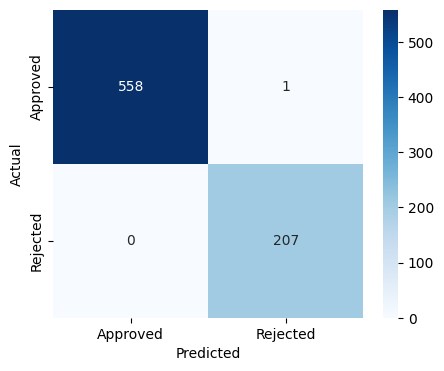

In [13]:
def print_confusion_matrix(dataloader, model):
    model.eval()
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for X, y in dataloader:
            X = X.to(device)
            y = y.float().to(device)

            pred = model(X)                 
            probs = torch.sigmoid(pred)     
            preds = (probs > 0.5).int()    

            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(y.cpu().numpy())

    
    all_preds = np.array(all_preds).reshape(-1)
    all_labels = np.array(all_labels).reshape(-1)

    cm = confusion_matrix(all_labels, all_preds)
    print("Confusion Matrix:")
    print(cm)

    # Optional: pretty heatmap
    plt.figure(figsize=(5,4))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=['Approved','Rejected'],
                yticklabels=['Approved','Rejected'])
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.show()
    
print_confusion_matrix(test_loader, model)